### Imports

In [7]:
import torch
from torch import nn
import torch.nn.functional as F
from torch import optim

import matplotlib.pyplot as plt
import math
import numpy as np
import  wandb
import os
import time

from torchmetrics import Dice
import segmentation_models_pytorch as smp

## depend to the files of the project
import utils 
from utils import load, save, plot
from Benchmark import dataset
from methods import unet, unetplusplus, deeplab, transunet
from utils import load, save, plot

### Loading the WandB

In [3]:
key_file = './wandb-key.txt'

if os.path.exists(key_file):
    with open(key_file) as f:
        key = f.readline().strip()
    wandb.login(key=key)
else:
    print("Key file does not exist. Please create the key file with your wandb API key.")

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: sepehr-eslami2019 (face-estimation). Use `wandb login --relogin` to force relogin
wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: C:\Users\USER/.netrc


### Arguments

In [6]:
seed = 3
wandb_enable = True

info = {'num_epoch' :5,
        'lr' : 0.3,
        'weight_decay' : 0.0001,
        'device' : 'cuda',
        'reset': True,
        'name_load' : 'pretrain-unet-efficientnet',
        'model_load_path' : './saved_model/',
        'model_save_path' : './saved_model/'
        }


Initialize `wandb`

In [5]:
wandb_arg_name = 'Pretrained Unet(efficientnet)' # name of this training process
wandb.init(
        project='Brain tumor segmentation',  # name of the project
        name=wandb_arg_name,
        config={
            'lr': info['lr'],
            'weight_decay': info['weight_decay'],
            'num_epoch': info['num_epoch']
        }
    )


### Main Loop

In [8]:
loss_train_hist = []
loss_valid_hist = []

metric_train_hist = []
metric_valid_hist = []

best_loss_valid = torch.inf
epoch_counter = 0

Deffine the `Dataloader`

In [12]:
train_batch_size = 54
valid_batch_size = 64


train_loader = dataset.BraTS20("./Benchmark", 'train', mini=False, memory=False)(batch_size=train_batch_size)
valid_loader = dataset.BraTS20("./Benchmark", 'valid', mini=False, memory=False)(batch_size=valid_batch_size)

 Define the `Model` - `Optimizer` - `Loss Function` - `Metric`

In [10]:
load_path = info['model_load_path'] + info['name_load'] + ".pth"

###############
#    Model    #
###############

# model = unet.UNet(n_channels=3, n_classes=3, bilinear=False).to(info['device'])  ## my unet arhitesture
model = unet.pre_train_unet(in_channels=4, classes=4, encoder_name='efficientnet-b1').to(info['device'])  ## Pre-trained unet with efficientnet encoder
# model = unetplusplus.UnetPlusPlus(encoder_name='resnet18').to(info['device'])  ## Pre-trained unet++ archoteture with efficientnet encoder 
# model = deeplab.DeepLab(encoder_name='efficientnet-b1').to(info['device'])  ## Pre-trained DeepLabv3 archoteture with efficientnet encoder 
# model = transunet.TransUNet(img_dim=224, in_channels=3, class_num=3).to(info['device'])


optimizer = optim.SGD(model.parameters(), lr=info['lr'], weight_decay=info['weight_decay'], momentum=0.9)# , nesterov=True
lr_scheduler = optim.lr_scheduler.MultiStepLR(optimizer, milestones=[3, 6], gamma=0.5)

loss_fn = smp.losses.DiceLoss(mode='multilabel')
# loss_fn = Criterion()

metric = Dice().to(info['device'])

model, loss_fn, _ = load(model, loss_fn, optimizer, device=info['device'], reset = info['reset'], load_path = load_path)

save_path = info['model_save_path'] + info['name_load']+ ".pth"

In [15]:
optimizer = optim.SGD(model.parameters(), lr=0.03, weight_decay=info['weight_decay'], momentum=0.9)
# scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer,T_max=int(30000/32*10)+50, 
#                                                    eta_min=1e-6) 

**`Training`**

In [13]:
epochs = info['num_epoch']

for epoch in range(1, epochs+1):
    ## Train
    model, loss_train, metric_train = utils.train_one_epoch(model,
                                                            # valid_loader,
                                                            train_loader,
                                                            loss_fn,
                                                            optimizer,
                                                            metric,
                                                            epoch,
                                                            device=info['device'])
    
    ## Validation
    loss_valid, metric_valid = utils.evaluate(model,
                                              valid_loader,
                                              loss_fn,
                                              metric,
                                              device=info['device'])

        
    loss_train_hist.append(loss_train)
    loss_valid_hist.append(loss_valid)

    metric_train_hist.append(metric_train)
    metric_valid_hist.append(metric_valid)


    print(f'Train      - Loss:{loss_train}  Metric:{metric_train}')
    print(f'Validation - Loss:{loss_valid}  Metric:{metric_valid}')
    print(f'LR = {lr_scheduler.get_last_lr()[0]}')
    print()

    if loss_valid < best_loss_valid:
        save(save_path, model, optimizer, loss_fn)
        best_loss_valid = loss_valid
        print('Model Saved ("o")')

    if wandb_enable:
        wandb.log({"metric_train": metric_train, "loss_train": loss_train,
                   "metric_valid": metric_valid, "loss_valid": loss_valid})
        
    lr_scheduler.step()

    epoch_counter += 1





Epoch 1: 100%|██████████| 721/721 [49:29<00:00,  4.12s/batch, loss=0.338, metric=0.977]  


Train      - Loss:0.3376648724079132  Metric:0.9773927330970764
Validation - Loss:0.24540920555591583  Metric:0.9889357089996338
LR = 0.3

Model Saved ("o")


Epoch 2: 100%|██████████| 721/721 [43:35<00:00,  3.63s/batch, loss=0.186, metric=0.993]


Train      - Loss:0.18565276265144348  Metric:0.9934394359588623
Validation - Loss:0.4553113281726837  Metric:0.5302287340164185
LR = 0.3



Epoch 3: 100%|██████████| 721/721 [43:26<00:00,  3.62s/batch, loss=0.174, metric=0.994]


Train      - Loss:0.17397522926330566  Metric:0.9937406778335571
Validation - Loss:0.20512525737285614  Metric:0.9739822745323181
LR = 0.3

Model Saved ("o")


Epoch 4: 100%|██████████| 721/721 [44:16<00:00,  3.69s/batch, loss=0.141, metric=0.994]


Train      - Loss:0.14074423909187317  Metric:0.9944784045219421
Validation - Loss:0.16082654893398285  Metric:0.9941924810409546
LR = 0.15

Model Saved ("o")


Epoch 5: 100%|██████████| 721/721 [43:05<00:00,  3.59s/batch, loss=0.146, metric=0.995]


Train      - Loss:0.14561402797698975  Metric:0.9947564601898193
Validation - Loss:0.14688391983509064  Metric:0.9962279200553894
LR = 0.15

Model Saved ("o")


In [41]:
wandb.finish()

loss_train,█▄▄▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁
loss_valid,█▇█▃▃▄▃▂▂▃▂▂▃▁▃▂▂▂▂▄▁▁▁▁▁▁▁▁▁▁
metric_train,▁▅▅▆▆▆▇▇▇▇▇▇▇▇▇▇▇▇▇▇██████████
metric_valid,▂▂▁▆▆▅▆▇▇▅▇▇▇█▆▇▇▇▇▅██████████
loss_train,0.06232
loss_valid,0.11595
metric_train,0.88952
metric_valid,0.79693


In [10]:
save(save_path, model, optimizer, loss_fn)

### Plot learning curves


Trained 5 epochs


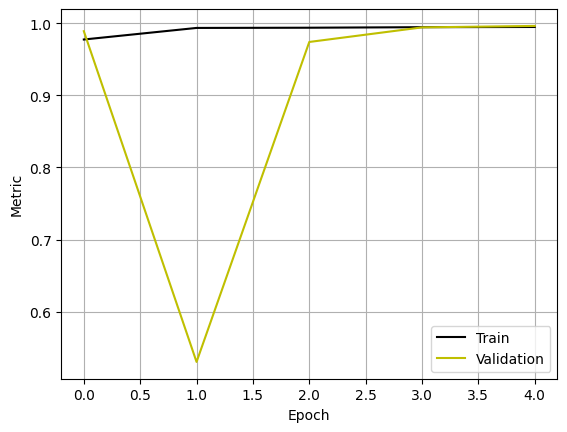


Trained 5 epochs


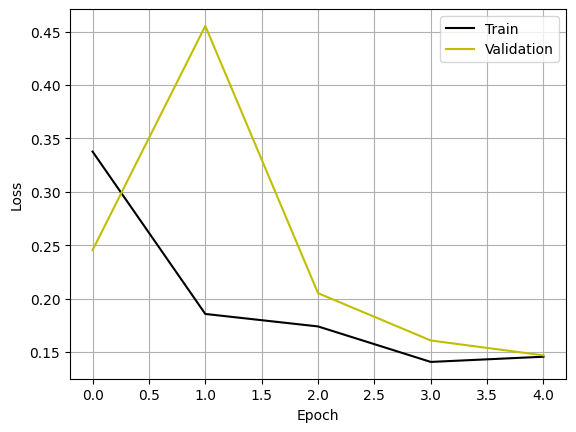

In [14]:
plot(metric_train_hist, metric_valid_hist, "Metric")
plot(loss_train_hist, loss_valid_hist, 'Loss')